In [67]:
import ee
import numpy as np
import pandas as pd
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *

from osgeo import gdal, osr

# Tensorflow setup.
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [68]:
# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

mkdir: cannot create directory ‘/root/.config/earthengine/’: File exists


### Crop an image patch for prediction

In [4]:
# import urban-img and terrain data
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [5]:
# define the year-range
year = [f'{i}_{i+2}' for i in range(1990,2020,3)]
year_img_val_dict = {yr:i for yr,i in zip(year,range(10,0,-1))}

In [6]:
# define the limit_list that controls the periods included
limit_list = [19]

In [7]:
# is the samples comes from mixed year? e.g. randomly sample training patches from 1990-2019. 
MIX_YEAR = False  # True/False

# if MIX_YEAR is included, is the year(e.g., 2017) used as a layer?
YEAR = False  # True/False

# include road as a predictor?
ROAD = False  # True/False


# judge to set the Feature for prediction/name for export
if ROAD:
  FEATURES   = ['built_up_t0', 'elevation', 'slope', 'distance', 'built_up_t1']
  FEATURES_pred = ['built_up_t1', 'elevation', 'slope', 'distance', 'built_up_t2']
  model_folder = '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_with_distance_to_roads' 
  sample_folder = 'urban_prj_distance' 
else:
  FEATURES   = ['built_up_t0', 'elevation', 'slope', 'built_up_t1']
  FEATURES_pred = ['built_up_t1', 'elevation', 'slope', 'built_up_t2']
  model_folder = '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_no_distance_to_roads'
  sample_folder = 'urban_prj'


# judge to include the "year(num)" as a predictor
if MIX_YEAR and YEAR:
  FEATURES.insert(-1,'year')
  FEATURES_pred.insert(-1,'year')
  model_folder = '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_year' 
  sample_folder = 'urban_prj_mix_year'
elif MIX_YEAR:
  model_folder = '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year' 
  sample_folder = 'urban_prj_mix_no_year'


# Specify the export folder that stores the whole img to be classified
EXPORT_FOLDER = f'/content/G_drive/MyDrive/{sample_folder}'

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

FEATURES_DICT = {k:tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in  FEATURES}
FEATURES_DICT_pred = {k:tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES_pred}

In [9]:
# get all possible years for traning the projection
proj_yr = []
for k,v in year_img_val_dict.items():
  # get the t0 val/img
  t0 = k
      
  # get the t1;t2
  if v == 2:
      pass
  else:
    for val in range(v-1,1,-1):
      prj_val = val - (v - val)
      
      if  prj_val>0:
        
        prj_yr  = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
        
        t1 = [k for k,v in year_img_val_dict.items() if v==val][0]
        t2 = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                        
        proj_yr.append((t0,t1,t2))

In [10]:
# create the training patch
train_data = []

for t in proj_yr:
    
    # get the time
    t0 = t[0]
    t1 = t[1]
    t2 = t[2]
    proj_times = year_img_val_dict[t0] - year_img_val_dict[t1]
    proj_years = proj_times*3
    
    # get the built-up layer
    t0_img,t1_img,t2_img = [urban.gte(year_img_val_dict[yr]).rename(f'built_up_t{i}') for i,yr in enumerate(t)]
    
    # get the expansion mask
    expansion_mask = t1_img.subtract(t0_img).rename('expansion')
    expansion_prj  = t2_img.subtract(t1_img).rename('expansion')
    
    # import the Distance_to_built-up imgs//  NOTE!!!! currently we only have the road back to 2013
    Distance_t0 = ee.Image("users/wangjinzhulala/GEE_TF/Distance_imgs/Dist_road_2013").rename('distance')
    Distance_t1 = ee.Image("users/wangjinzhulala/GEE_TF/Distance_imgs/Dist_road_2016").rename('distance')

    # get the last year to indicate the data of urban image
    year_t0 = ee.Image(int(t0.split('_')[1])).rename('year')
    year_t1 = ee.Image(int(t1.split('_')[1])).rename('year')
    year_t2 = ee.Image(int(t2.split('_')[1])).rename('year')

    # import DEM and SLOPE
    DEM = ee.Image("USGS/SRTMGL1_003")
    SLOPE = ee.Terrain.slope(DEM)
    
    # stack all bands for later tranin/eval
    train_eval_bands = t0_img.addBands(DEM).addBands(SLOPE).addBands(Distance_t0).addBands(year_t0).addBands(t1_img).select(FEATURES).toFloat()
    pred_bands    = t1_img.addBands(DEM).addBands(SLOPE).addBands(Distance_t1).addBands(year_t1).addBands(t2_img).select(FEATURES_pred).toFloat()

    
    # convert img to neighboorhood-array
    list_1d = ee.List.repeat(1, KERNEL_SIZE)
    list_2d = ee.List.repeat(list_1d, KERNEL_SIZE)
    kernel  = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, list_2d)

    arrays_train_eval = train_eval_bands.neighborhoodToArray(kernel)
    arrays_pred = pred_bands.neighborhoodToArray(kernel)
    
    # add patch to a dict
    train_data.append([t0,t1,t2,proj_times,proj_years,arrays_train_eval,arrays_pred,pred_bands])

In [11]:
train_data = pd.DataFrame(train_data,columns = ['t0','t1','t2','proj_times','proj_years','arrays_train_eval','arrays_pred','img_to_proj'])
train_data

,t0,t1,t2,proj_times,proj_years,arrays_train_eval,arrays_pred,img_to_proj
0,1990_1992,1993_1995,1996_1998,1,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,1990_1992,1996_1998,2002_2004,2,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,1990_1992,1999_2001,2008_2010,3,9,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,1990_1992,2002_2004,2014_2016,4,12,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,1993_1995,1996_1998,1999_2001,1,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
5,1993_1995,1999_2001,2005_2007,2,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
6,1993_1995,2002_2004,2011_2013,3,9,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
7,1993_1995,2005_2007,2017_2019,4,12,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
8,1996_1998,1999_2001,2002_2004,1,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
9,1996_1998,2002_2004,2008_2010,2,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


#### Download the image patch

In [38]:
# prepare the img_patch in GEE
region = ee.Geometry.Polygon(
        [[[115.79595938326838, 33.434969411748156],
          [115.79595938326838, 33.22384442502368],
          [116.06855764986994, 33.22384442502368],
          [116.06855764986994, 33.434969411748156]]])
img_to_pred = train_data.iloc[limit_list]['img_to_proj'].values[0].clip(region)
url = img_to_pred.getDownloadURL(params = {'name':'img_to_pred','scale':30,'region':region})

# download the img_patch
import urllib
urllib.request.urlretrieve(url, "./img_to_pred.zip")

# unzip the downloaded data
import zipfile
with zipfile.ZipFile("./img_to_pred.zip", 'r') as zip_ref:
    zip_ref.extractall('./')

In [83]:
# stack all features to a 3-dimisional array
array_to_pred = []
for fe in img_to_pred.bandNames().getInfo()[:-1]:
  ds = gdal.Open(f'./img_to_pred.{fe}.tif')
  ds_arr = ds.GetRasterBand(1).ReadAsArray()
  array_to_pred.append(ds_arr[:512,:512])

# change CHW to HWC, add a "sample dimension" to it
array_to_pred = np.transpose(array_to_pred,[1,2,0])
array_to_pred = np.expand_dims(array_to_pred,0)

In [84]:
array_to_pred.shape

(1, 512, 512, 3)

### Make prediction

In [41]:
m = tf.keras.models.load_model(f'/content/drive/MyDrive/Urban_prj_models/FCNN_models_no_distance_to_roads/FCNN_1999_2001_and_2008_2010_prj_2017_2019_100.pb')

In [ ]:
plot_model(m)

In [148]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [151]:
# get the activation layer right after each dowm-sampling conv block
activation_layers = [f'activation_{i}' for i in list(range(1,12,2)) + list(range(14,27,3))] + ['conv2d_22']

In [152]:
[(idx,ly.name,ly.output_shape) for (idx,ly) in enumerate(m.layers) if ly.name in activation_layers]

[(6, 'activation_1', (None, None, None, 32)),
 (13, 'activation_3', (None, None, None, 64)),
 (20, 'activation_5', (None, None, None, 128)),
 (27, 'activation_7', (None, None, None, 256)),
 (34, 'activation_9', (None, None, None, 512)),
 (41, 'activation_11', (None, None, None, 1024)),
 (51, 'activation_14', (None, None, None, 512)),
 (61, 'activation_17', (None, None, None, 256)),
 (71, 'activation_20', (None, None, None, 128)),
 (81, 'activation_23', (None, None, None, 64)),
 (91, 'activation_26', (None, None, None, 32)),
 (92, 'conv2d_22', (None, None, None, 1))]

In [171]:
# redefine model to the activation layer after the convolution layer
model = Model(inputs=m.inputs, outputs=m.layers[91].output)

In [172]:
# get predictions
feature_maps = model.predict(array_to_pred)
final_out = m.predict(array_to_pred)

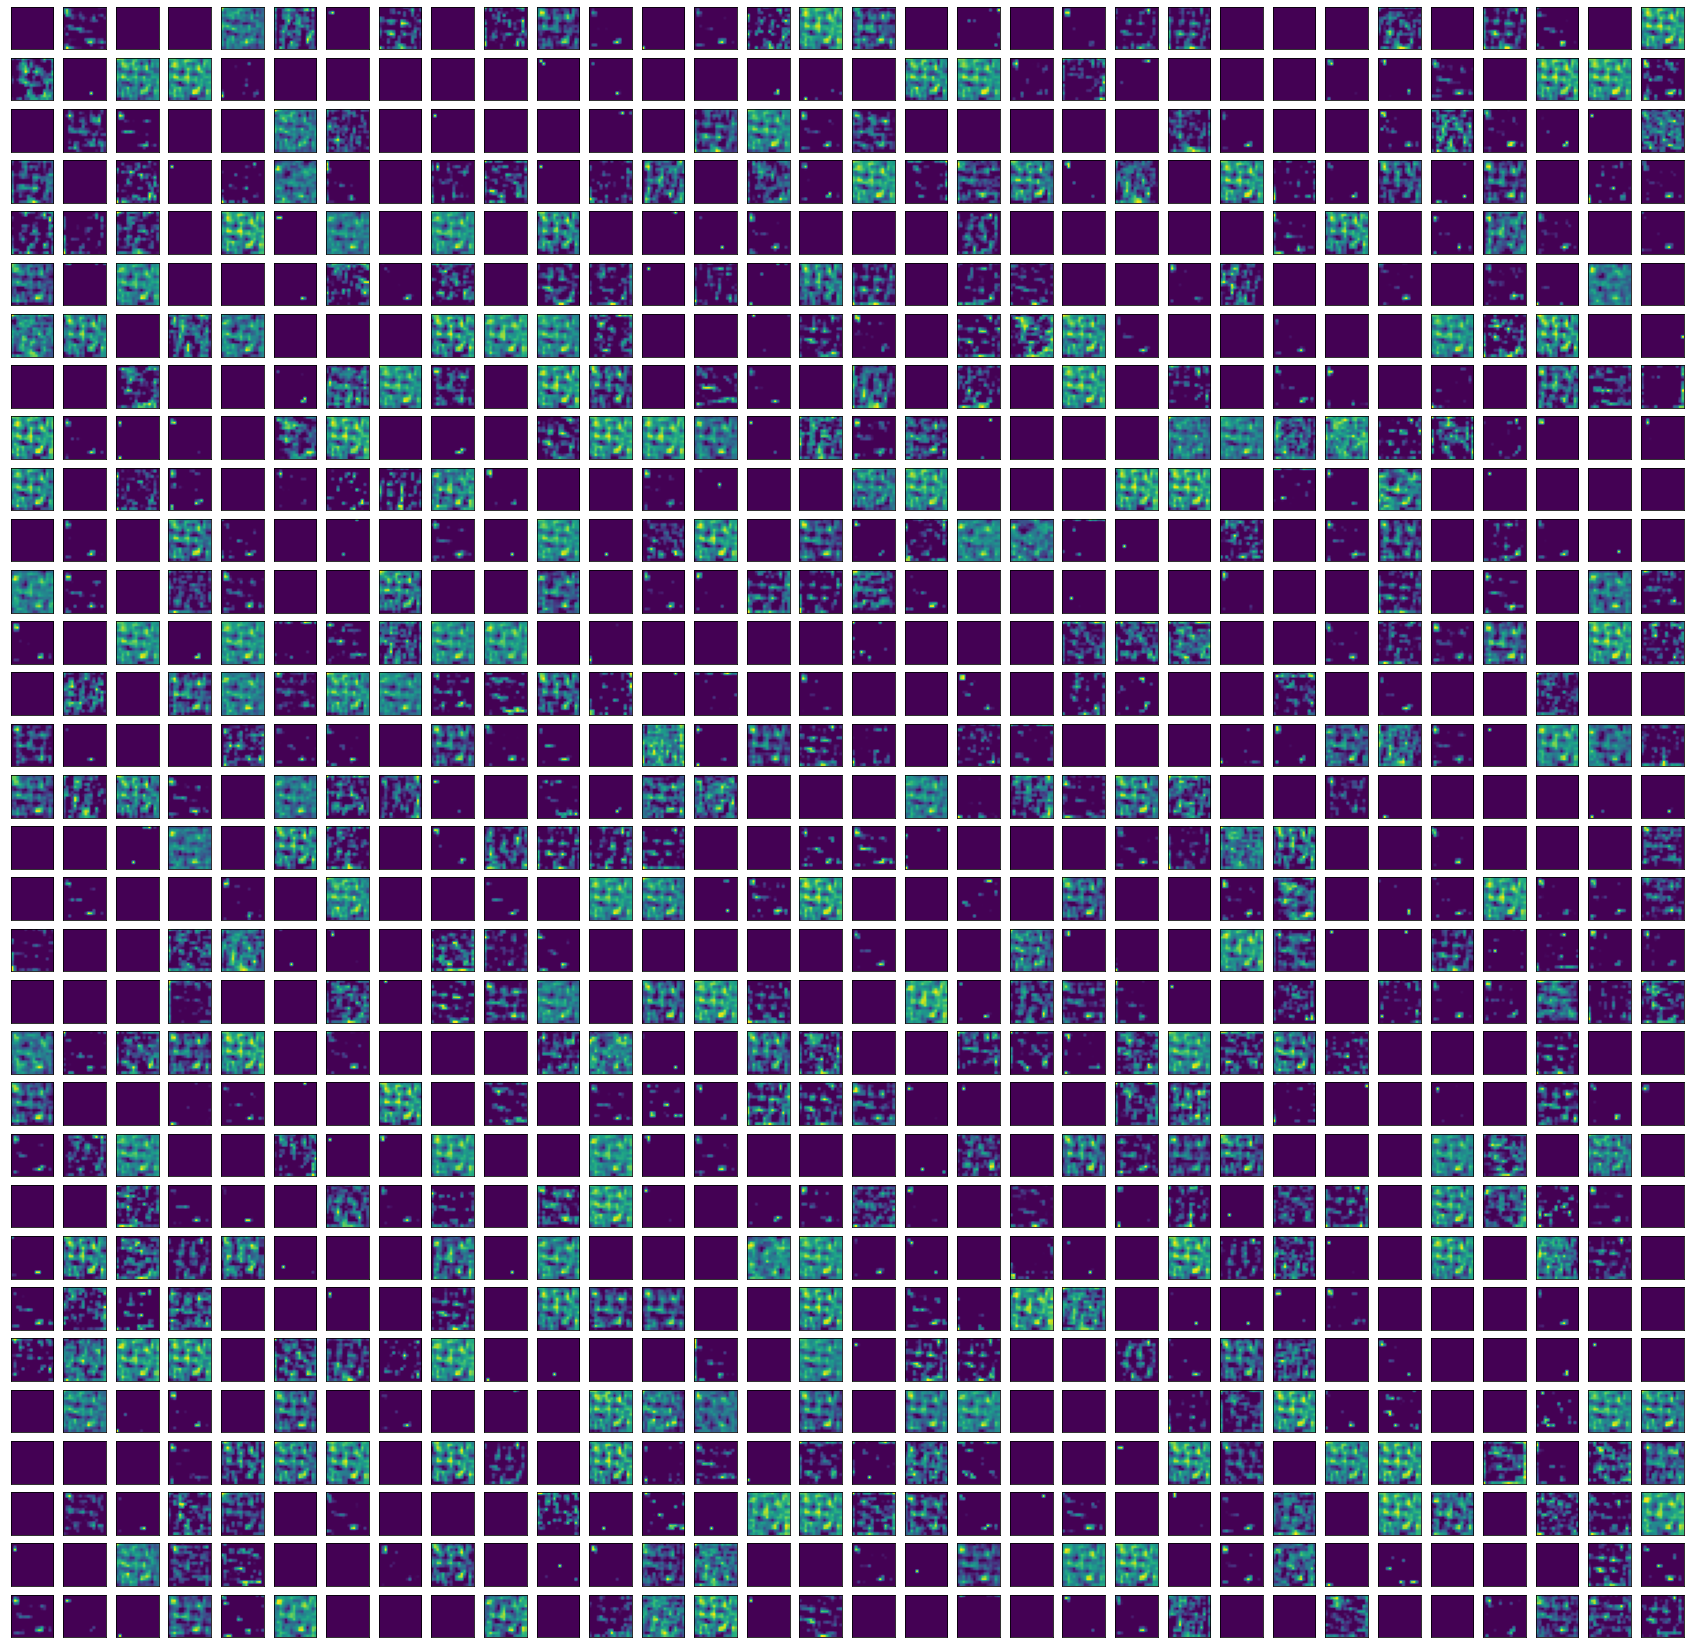

In [173]:
width = 30
height = 30
ix = 1

# show the figure
plt.figure(figsize=(30,15))

for _ in range(height):
	for _ in range(width):
		# specify subplot and turn of axis
		ax = plt.subplot(height, width, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1])
		ix += 1

(-0.5, 511.5, 511.5, -0.5)

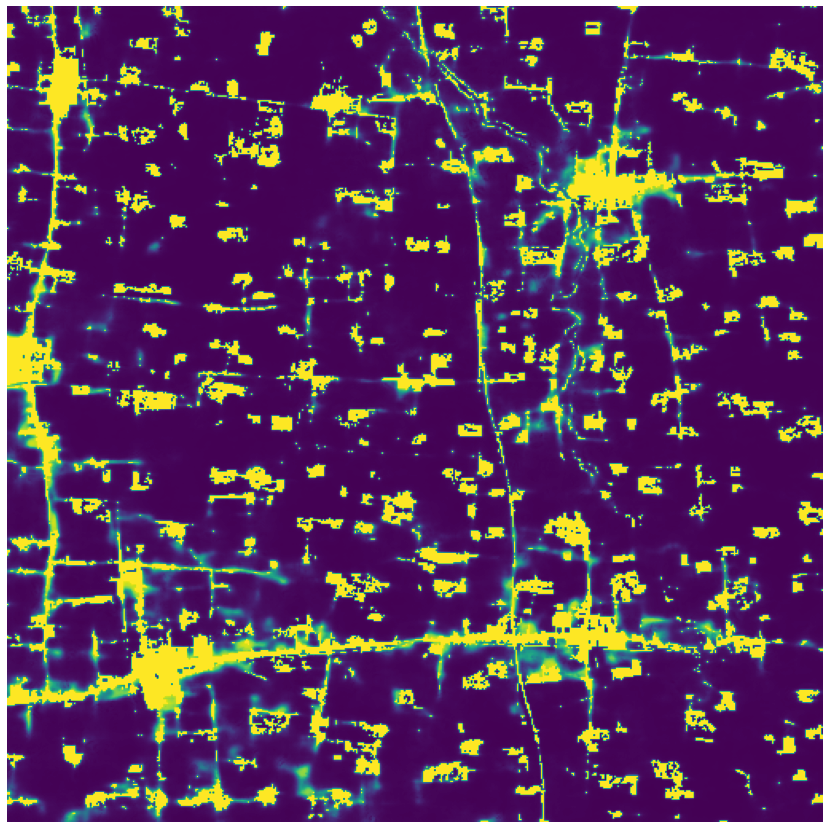

In [170]:
plt.figure(figsize=(30,15))


plt.imshow(final_out[0, :, :, 0])
plt.axis('off')
